In [2]:
import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

/home/kavya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv("../data/drug_class_identification/phase1/drugbank.csv")
df.head(100)
df.drop(df[df.smiles.isna()].index, inplace = True)
df.drop(df[df.atc.isna()].index, inplace = True)
df.drop(df[[False if len(smile)<250 else True for smile in df.smiles]].index, inplace = True)

In [4]:
df['atc1'] = [a[0] for a in df['atc']]

In [5]:
df.head()

,name,atc,inchi_key,smiles,atc1
13,goserelin,L02AE03,BLCLNMBMMGCOAS-URPVMXJPSA-N,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,L
33,desmopressin,H01BA02,NFLWUMRGJYTJIN-NXBWRCJVSA-N,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,H
47,cetrorelix,H01CC02,SBNPWPIBESPSIF-MHWMIDJBSA-N,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,H
84,ciclosporin,L04AD01,PMATZTZNYRCHOR-CGLBZJNRSA-N,CC[C@@H]1NC(=O)[C@H]([C@H](O)[C@H](C)C\C=C\C)N...,L
95,octreotide,H01CB02,DEQANNDTNATYII-OULOTJBUSA-N,[H][C@]1(NC(=O)[C@H](CCCCN)NC(=O)[C@@H](CC2=CN...,H


In [6]:
df.describe()

,name,atc,inchi_key,smiles,atc1
count,2737,2737,2737,2737,2737
unique,2737,2640,2737,2737,14
top,cyclandelate,J01CR50,ZMZNLKYXLARXFY-UHFFFAOYSA-H,COCCCC\C(=N/OCCN)C1=CC=C(C=C1)C(F)(F)F,N
freq,1,22,1,1,469


In [7]:
df['smiles'] = [smile.ljust(250, '*') for smile in df['smiles']] 

### One Hot Encoding

In [8]:
vocabulary = set()
allSmiles = ""
for smile in df['smiles']:
    allSmiles+=smile
    for char in smile:
        vocabulary.add(char)
freq = Counter(allSmiles).most_common(25)

In [9]:
vocabulary = [a for a,b in freq]

In [10]:
'*' in vocabulary

True

In [11]:
oe = OneHotEncoder(handle_unknown='ignore')
oe.fit(np.asarray(vocabulary).reshape(-1, 1))

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [12]:
def encodeSmile(smile, oe):
    word = []
    for char in smile:
        temp = list(oe.transform(np.asarray([char]).reshape(1, -1)).toarray()[0])
        word = word + temp
    return np.asarray(word, dtype=int)

In [13]:
X = []
X = [encodeSmile(smile, oe) for smile in df['smiles']]

In [14]:
X = np.asarray(X)

In [15]:
ATCclasssubset = ['A', 'J', 'N', 'C']
num_classes = len(ATCclasssubset)

X_df = pd.DataFrame(X)
X_df['target'] = df['atc1']
X_df = X_df[X_df['target'].isin(ATCclasssubset)]
g = X_df.groupby('target')
X_df = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

X = X_df[X_df.columns[:-1]]

### Prepare Data

In [16]:
oeAtc = OneHotEncoder()
y = oeAtc.fit_transform(np.asarray(X_df['target']).reshape(-1, 1)).toarray()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
temp = [[0 for b in range(0, num_classes)] for a in range(0, num_classes)]
for a in range(0, num_classes):
    temp[a][a] = 1
temp = np.asarray(temp)
atc_classes = oeAtc.inverse_transform(temp).reshape(num_classes)

### Helper function

In [19]:
def accuracy(y_true, y_pred, atc_classes=atc_classes):
    print("Overall Accuracy:", np.sum(np.equal(y_true, y_pred))/y_true.shape[0])
    matrix = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix,annot=True,cbar=False, xticklabels=atc_classes, yticklabels=atc_classes)

### Make the network

In [20]:
class Network:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Reshape((250, 25), input_shape=(6250, )))
        self.model.add(Conv1D(192, 5, activation='relu', input_shape=(250, 25)))
        self.model.add(MaxPool1D(5))
        self.model.add(BatchNormalization())        
#         self.model.add(Conv1D(192, 5, activation='relu'))
        self.model.add(Conv1D(140, 3, activation='relu'))
#         self.model.add(LSTM(70, dropout=0.7, recurrent_dropout=0.2, activation='selu', return_sequences=True,))
#         self.model.add(LSTM(70, dropout=0.4, recurrent_dropout=0.2, activation='relu'))
        self.model.add(Flatten())
#         self.model.add(Dense(100, activation='relu'))
        self.model.add(Dropout(rate=0.4))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, X, y, X_test, y_test, epochs=20):
        self.model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test))
    
    def test(self, X, y):
        y_pred = self.model.predict(X).argmax(axis=1)
        y_true = y.argmax(axis=1)
        accuracy(y_true, y_pred)
        

In [21]:
network = Network(num_classes)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 250, 25)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 246, 192)          24192     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 192)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 192)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 47, 140)           80780     
_________________________________________________________________
flatten_1 (Flatten)  

In [23]:
network.train(X_train, y_train, X_test, y_test, epochs=10)

Train on 324 samples, validate on 160 samples
Epoch 1/10
324/324 [==============================] - 1s 2ms/step - loss: 0.2078 - acc: 0.9599 - val_loss: 2.1527 - val_acc: 0.2062
Epoch 2/10
324/324 [==============================] - 1s 2ms/step - loss: 0.2053 - acc: 0.9630 - val_loss: 2.3420 - val_acc: 0.1812
Epoch 3/10
324/324 [==============================] - 1s 2ms/step - loss: 0.1547 - acc: 0.9753 - val_loss: 2.1887 - val_acc: 0.2062
Epoch 4/10
324/324 [==============================] - 1s 2ms/step - loss: 0.1156 - acc: 0.9938 - val_loss: 2.2724 - val_acc: 0.2125
Epoch 5/10
324/324 [==============================] - 1s 2ms/step - loss: 0.1114 - acc: 0.9877 - val_loss: 2.4466 - val_acc: 0.2000
Epoch 6/10
324/324 [==============================] - 1s 2ms/step - loss: 0.0913 - acc: 0.9877 - val_loss: 2.4426 - val_acc: 0.1812
Epoch 7/10
324/324 [==============================] - 1s 2ms/step - loss: 0.0815 - acc: 0.9907 - val_loss: 2.5356 - val_acc: 0.1812
Epoch 8/10
324/324 [==========

Overall Accuracy: 0.24375
              precision    recall  f1-score   support

           0       0.33      0.21      0.26        53
           1       0.18      0.37      0.24        30
           2       0.21      0.30      0.25        30
           3       0.33      0.17      0.23        47

   micro avg       0.24      0.24      0.24       160
   macro avg       0.26      0.26      0.24       160
weighted avg       0.28      0.24      0.24       160



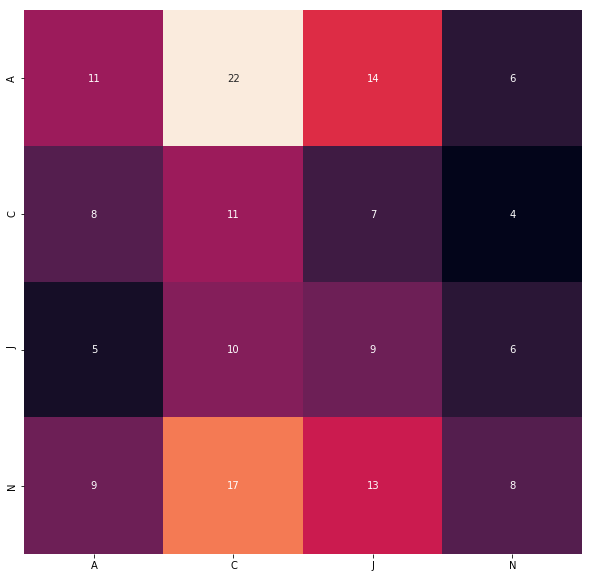

In [330]:
s = network.test(X_test, y_test)